# Notebook 1: Estimating Rates

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [2]:
import matplotlib.pyplot as plt

import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Poisson process

I'll model hockey as a Poisson process, where each team has some long-term average scoring rate, $\mu$, in goals per game.

To get started, let's assume that $\mu$ is somehow known to be 2.4 goals per game.

We can use PyMC to generate a sample from a Poisson distribution.

In [3]:
import pymc3 as pm

mu = 2.4
sample_poisson = pm.Poisson.dist(mu).random(size=1000)
np.mean(sample_poisson)

2.385

To show the distribution of the quantities, I'll use the following function, which returns a Pandas `Series`.

In [4]:
import pandas as pd

def make_pmf(sample):
    """Make a Series that represents a PMF.
    
    sample: sequence of quantities
    
    returns: Pandas Series
    """
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

The index of the `Series` contains the possible quantities; the values in the `Series` are their probabilities.

In [5]:
pmf_poisson = make_pmf(sample_poisson)
pmf_poisson

0    0.086
1    0.237
2    0.250
3    0.196
4    0.144
5    0.050
6    0.026
7    0.010
8    0.001
dtype: float64

The following function takes a sample and plots the PMF as a bar chart.

In [6]:
def plot_pmf(sample, **options):
    """Plot the PMF of a sample as a bar chart."""
    pmf = make_pmf(sample)
    plt.bar(pmf.index, pmf.values, **options)

And this one decorates the axes.

In [7]:
def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')

    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

Here's what the distribution looks like.

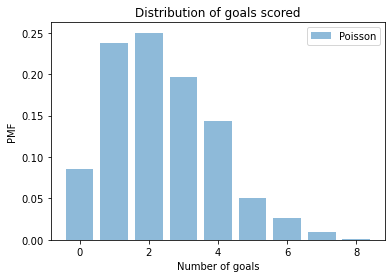

In [8]:
plot_pmf(sample_poisson, label='Poisson', alpha=0.5)
decorate_goals()

## The gamma distribution

In [9]:
alpha = 4.4
beta = 1.8

In [10]:
sample_gamma = pm.Gamma.dist(alpha, beta).random(size=1000)

In [11]:
def decorate_rate(ylabel='Density'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

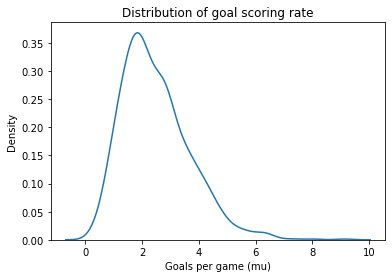

In [12]:
import seaborn as sns

sns.kdeplot(sample_gamma)
decorate_rate()

## Back to PyMC

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from a gamma distribution of `mu`, with known `alpha` and `beta`.

And then use that value of `mu` to draw a sample from a Poisson distribution.

Here's what the PyMC model looks like:

In [13]:
alpha = 4.4
beta = 1.8

In [14]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    trace = pm.sample_prior_predictive(1000)

In [15]:
sample_prior = trace['mu']
np.mean(sample_prior)

2.398903614343279

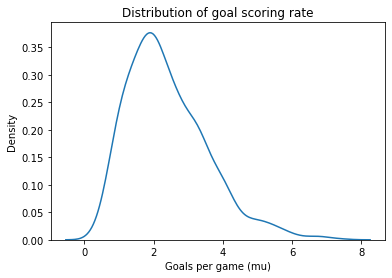

In [16]:
sns.kdeplot(sample_prior)
decorate_rate('Density')

## The prior predictive distribution

We can get a sample of `goals` from the trace.

In [17]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

This model generates two variables:

1. Values of `mu` drawn from the prior distribution.

2. Values of `goals` drawn from the prior predictive distribution.

Remember that `mu` is a rate in goals per game, and `goals` is an integer number of goals.

The distribution of `mu` from this model is the prior.  Let's see what it looks like:

In [18]:
sample_prior_pred = trace['goals']
sample_prior_pred.mean()

2.373

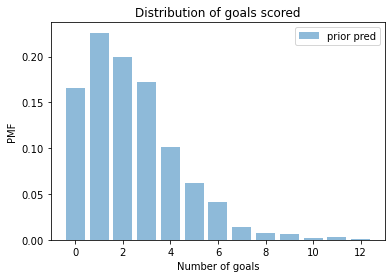

In [19]:
plot_pmf(sample_prior_pred, label='prior pred', alpha=0.5)
decorate_goals()

In [35]:
sample_poisson.mean(), sample_prior_pred.mean()

(2.385, 2.373)

In [36]:
sample_poisson.std(), sample_prior_pred.std()

(1.5351791426410144, 1.9768335792372609)

The prior predictive distribution shows the distribution of goals we should expect in a game, based on the prior distribution only, not the data.

It is useful for model-checking, but it is also a step along the way to inference.

## When do we get to inference?

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `4`.

And instead of calling `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [20]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  

In [21]:
len(trace['mu'])

2000

In [22]:
sample_posterior = trace['mu']
np.mean(sample_posterior)

3.0498218232883985

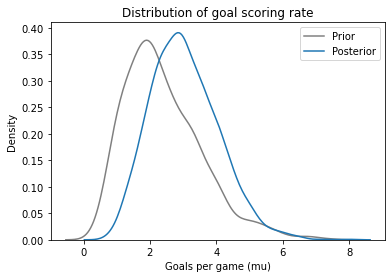

In [37]:
import seaborn as sns

sns.kdeplot(sample_prior, label='Prior', color='gray')
sns.kdeplot(sample_posterior, label='Posterior')
decorate_rate('Density')

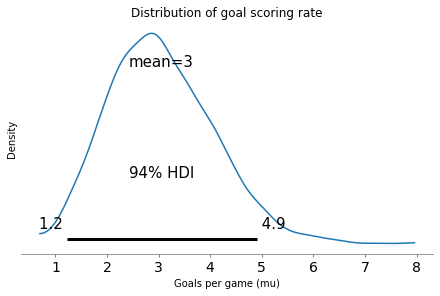

In [24]:
import arviz as az

az.plot_posterior(sample_posterior)
decorate_rate('Density')

**Exercise:** The example we've run so far is based on three parameters: the values of `alpha` and `beta` that determine the prior distribution, and the observed number of goals.

Modify any of these variables and run the example again to see what effect they have.

## Two teams

We can extend the model to estimate different values of `mu` for two teams.

In [25]:
alpha = 4.4
beta = 1.8

In [26]:
model = pm.Model()

with model:
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    mu_MTL = pm.Gamma('mu_MTL', alpha, beta)
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[5])
    goals_MTL = pm.Poisson('goals_MTL', mu_MTL, observed=[1])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_MTL, mu_TBL]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


We can use `traceplot` to review the results and do some visual diagnostics.

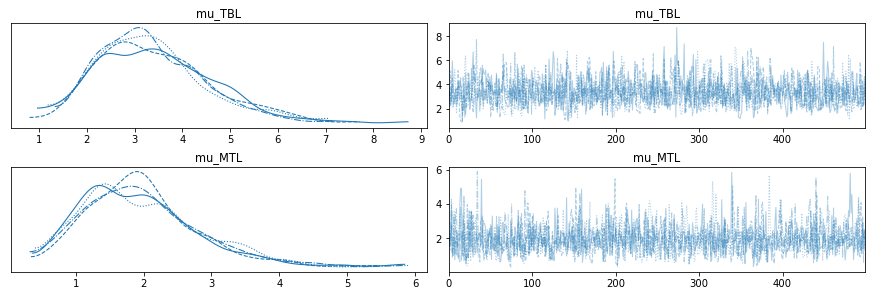

In [27]:
with model:
    az.plot_trace(trace);

Here are the posterior distribitions for `mu_MTL` and `mu_TBL`.

In [28]:
mu_TBL = trace['mu_TBL']
mu_MTL = trace['mu_MTL']
np.mean(mu_MTL), np.mean(mu_TBL)

(1.9585755128823483, 3.3800971406081564)

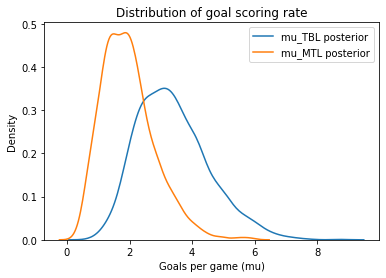

In [29]:
sns.kdeplot(mu_TBL, label='mu_TBL posterior')
sns.kdeplot(mu_MTL, label='mu_MTL posterior')
decorate_rate('Density')

On the basis of these two games, here's the probability that Tampa Bay is the better team.

In [30]:
np.mean(mu_TBL > mu_MTL)

0.849

**Exercise:** Modify the previous example to take into account both games. How much does the second game affect the "probability of superiority"?

Hint: The observed data can be a list.